In [1]:
import pandas as pd
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
from cv2 import aruco

In [2]:
calibration_images_path = os.path.join(os.getcwd(), "calibration", "img*.png")
images = glob.glob(calibration_images_path)

In [3]:
aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_APRILTAG_16h5)
detectorParams = aruco.DetectorParameters()
detectorParams.cornerRefinementMethod = aruco.CORNER_REFINE_CONTOUR
detector = aruco.ArucoDetector(aruco_dict, detectorParams)

In [ ]:
marker_size = 168
marker_gap = 70

step_size = marker_size + marker_gap

top_left = [0, 0, 0]

aruco_marker = [
    [top_left[0], top_left[1] + marker_size, 0],    
    top_left,
    [top_left[0] + marker_size, top_left[1], 0],         
    [top_left[0] + marker_size, top_left[1] + marker_size, 0],   
]
aruco_marker = np.array(aruco_marker, dtype=np.float32)

aruco_board = []
for x in range(3):
    for y in range(2):    
        top_left = [x * step_size, (y) * step_size, 0]
        
        corners_3d = [
            [top_left[0], top_left[1] + marker_size, 0],
            top_left,
            [top_left[0] + marker_size, top_left[1], 0],    
            [top_left[0] + marker_size, top_left[1] + marker_size, 0],             
        ]
        
        aruco_board.extend(corners_3d)
aruco_board = np.array(aruco_board, dtype=np.float32)

mapping = {
    29:1,
    28:0,
    23:2,
    18:4,
    24:3,
    19:5,
}

## Task 1

### One Marker

In [5]:
objpoints = []
imgpoints = []

for image_path in images:
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    corners, ids, _ = detector.detectMarkers(gray)
    
    if ids is not None and len(ids) > 0:
        for marker in corners:
            points = marker.reshape(-1, 1, 2)
            points = points.astype('float32')
            imgpoints.append(points)
            objpoints.append(aruco_marker)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, gray.shape[::-1], None, None
)

In [10]:
objpoints = []
imgpoints = []

for image_path in images:
    image = cv2.imread(image_path)
    
    corners, ids, _ = detector.detectMarkers(image)
    ids = ids.reshape(-1)
    ids = [mapping[id] for id in ids]
    
    ord_corners = [None] * len(corners)
    for i, pos in enumerate(ids):
        ord_corners[pos] = corners[i]
    corners = tuple(ord_corners)

    points = np.array([])
    for corner in corners:
        marker = corner
        points = np.append(points, marker)

    points = points.reshape(-1, 1, 2)
    points = points.astype('float32')
    imgpoints.append(points)
    objpoints.append(aruco_board)

ret_board, mtx_board, dist_board, rvecs_board, tvecs_board = cv2.calibrateCamera(
    objpoints, imgpoints, [1280, 720], None, None
)

In [11]:
mtx

array([[914.46738401,   0.        , 661.940804  ],
       [  0.        , 914.65289568, 359.50521074],
       [  0.        ,   0.        ,   1.        ]])

In [12]:
mtx_board

array([[903.18747991,   0.        , 653.44621283],
       [  0.        , 902.20803044, 355.05321437],
       [  0.        ,   0.        ,   1.        ]])

For our solution, we will proceed with the camera matrix based on 168 pictures. There are multiple reasons why. For once, we can calibrate the camera using 168 instead of 28 pictures. On top of that, using board populates the errors that are made because of the connection between different markers, which is omitted whenusing 6 different pictures for calibration. Last, but not least, the callibration is a non-linear task, so the more data, the better the results are.

In [14]:
# for img in images:
#     size = (img.shape[1], img.shape[0])

#     alpha = 0.5
#     rect_camera_matrix = cv2.getOptimalNewCameraMatrix(mtx, dist, size, alpha)[0]
#     map1, map2 = cv2.initUndistortRectifyMap(mtx, dist, np.eye(3), rect_camera_matrix, size, cv2.CV_32FC1)

#     rect_img0 = cv2.remap(img, map1, map2, cv2.INTER_LINEAR)

#     cv2.imshow(cv2.hconcat([img, rect_img0]))
#     cv2.waitKey(500)
#     cv2.destroyAllWindows()

In [15]:
# for img_path in images:
#     img = cv2.imread(img_path)
#     size = (img.shape[1], img.shape[0])

#     alpha = 0.5
#     rect_camera_matrix = cv2.getOptimalNewCameraMatrix(mtx, dist, size, alpha)[0]
#     map1, map2 = cv2.initUndistortRectifyMap(mtx, dist, np.eye(3), rect_camera_matrix, size, cv2.CV_32FC1)

#     und_img = cv2.remap(img, map1, map2, cv2.INTER_LINEAR)
#     und_img = cv2.resize(und_img, (1280,720))
    
#     img_small = cv2.resize(img, (0, 0), None, 0.5, 0.5)
#     und_img_small = cv2.resize(und_img, (0, 0), None, 0.5, 0.5)
#     imstack = np.hstack([img_small, und_img_small])
#     cv2.imshow('Obrazki', imstack)
#     cv2.waitKey(500)
#     cv2.destroyAllWindows()

In [16]:
calibration_images_path = os.path.join(os.getcwd(), "stitching", "img*.png")
images = glob.glob(calibration_images_path)

for img_path in images:
    img = cv2.imread(img_path)
    size = (img.shape[1], img.shape[0])

    alpha = 0.
    rect_camera_matrix = cv2.getOptimalNewCameraMatrix(mtx, dist, size, alpha)[0]
    map1, map2 = cv2.initUndistortRectifyMap(mtx, dist, np.eye(3), rect_camera_matrix, size, cv2.CV_32FC1)

    und_image = cv2.remap(img, map1, map2, cv2.INTER_LINEAR)
    img_name = img_path.split('\\')[-1]
    cv2.imwrite(f'stitching_undistorted/{img_name}', und_image)
    cv2.imshow('Obrazki', und_image)
    cv2.waitKey(500)
    cv2.destroyAllWindows()

## Task 2

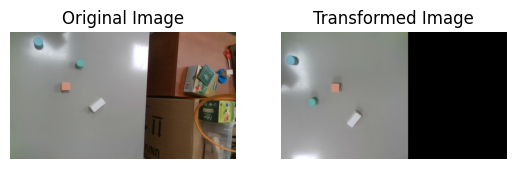

In [ ]:
def apply_projective_transform(image, H, output_size, visualize=False):
    """
    Apply a projective transformation to the image using a homography matrix H.
    Args:
        image: Input image as a NumPy array.
        H: 3x3 projective transformation matrix.
        output_size: Tuple (width, height) of the output image.
    Returns:
        Transformed image.
    """
    H_inv = np.linalg.inv(H) 
    
    transformed_image = np.zeros((output_size[1], output_size[0], 3), dtype=image.dtype)
    
    for y in range(output_size[1]):
        for x in range(output_size[0]):
            
            dest_coord = np.array([x, y, 1])
            
            source_coord = H_inv @ dest_coord
            source_x, source_y = source_coord[:2] / source_coord[2]
            
            source_x = int(round(source_x))
            source_y = int(round(source_y))
            
            if 0 <= source_x < image.shape[1] and 0 <= source_y < image.shape[0]:
                transformed_image[y, x] = image[source_y, source_x]
    if visualize:
        image_small = cv2.resize(image, (0, 0), None, 0.5, 0.5)
        transformed_image_small = cv2.resize(transformed_image, (0, 0), None, 0.5, 0.5)
        imstack = np.hstack([image_small, transformed_image_small])
        cv2.imshow('Obrazki', imstack)
        cv2.waitKey(500)
        cv2.destroyAllWindows()
        
    return transformed_image

image = cv2.imread(images[0])

H = np.array([
    [0, 1, 0],
    [1, 0, 0],
    [0, 0, 1]
])

output_size = (image.shape[1], image.shape[0])  

transformed_image = apply_projective_transform(image, H, output_size)

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Transformed Image")
plt.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()


## Task 3

In [18]:
def compute_homography(points_src, points_dst):
    """
    Find the homography that maps points_src to points_dst.
    """
    num_points = points_src.shape[0]

    assert num_points == points_dst.shape[0], "Number of source not equal to the destination"
    assert  num_points >= 4, "At least 4 points are required."
    
    A = []
    for i in range(num_points):
        x, y = points_src[i]
        u, v = points_dst[i]
        
        A.append([-x, -y, -1, 0, 0, 0, u * x, u * y, u])
        A.append([0, 0, 0, -x, -y, -1, v * x, v * y, v])
    
    A = np.array(A)
    
    _, _, V = np.linalg.svd(A)
    
    H = V[-1, :].reshape(3, 3)
    
    return H / H[2, 2]

def test_homography():
    for _ in range(10):
        H_true = np.random.rand(3, 3)
        H_true[2, 2] = 1
        
        num_points = 8
        points_src = np.random.rand(num_points, 2) * 100
        points_src_homogeneous = np.hstack([points_src, np.ones((num_points, 1))])
        
        points_dst_homogeneous = (H_true @ points_src_homogeneous.T).T
        points_dst = points_dst_homogeneous[:, :2] / points_dst_homogeneous[:, [2]]
        
        H_estimated = compute_homography(points_src, points_dst)
        
        H_true /= H_true[2, 2]
        H_estimated /= H_estimated[2, 2]
        
        assert np.allclose(H_true, H_estimated, atol=1e-6), "Homography estimation failed!"
    
    print("All tests passed!")

test_homography()


All tests passed!


## Task 4

In [46]:
def get_homography(img_1, img_2, conf=0.95):
    matches = np.load(f'matches/img{img_1}_img{img_2}_matches.npz')

    points_src = matches['keypoints0']
    points_dst = matches['keypoints1']
    mapping = matches['matches']
    confidence = matches['match_confidence']
    matches = output_array = np.full((len(mapping), points_dst.shape[1]), -1)

    valid_indices = (mapping != -1) & (confidence > conf)
    matches[valid_indices] = points_dst[mapping[valid_indices]]

    filtered_points_src = points_src[np.any(output_array != -1, axis=1)]
    filtered_points_dst = output_array[np.any(output_array != -1, axis=1)]

    H = compute_homography(filtered_points_src, filtered_points_dst)
    return H

def get_panorama(img_1, img_2, H, add_img_1=True):
    # dst = cv2.warpPerspective(img_2, H, ((img_1.shape[1] + img_2.shape[1]), img_1.shape[0] + img_2.shape[0]))
    dst = apply_projective_transform(img_2, H, ((img_1.shape[1] + img_2.shape[1]), img_1.shape[0] + img_2.shape[0]))
    if add_img_1==True:
        dst[0:img_1.shape[0], 0:img_1.shape[1]] = img_1

    max_h = np.max(np.where(dst != 0)[0])
    max_w = np.max(np.where(dst != 0)[1])
    dst = dst[:max_h, :max_w, :]
    
    return dst

In [47]:
img1_nr = 5
img2_nr = 6

In [48]:
img1_points = np.array([
    [989,454], #left upper corner white
    [1052,405], #left lower corner white
    [1076,434], #right upper corner white
    [1012,485], #right lower corner white
    [486,264], #left upper corner purple
    [514,250], #left lower corner purple
    [534,280], #right upper corner purple
    [507,295], #right lower corner purple
])

img2_points = np.array([
    [1100,463], #left upper corner white
    [1171,411], #left lower corner white
    [1200,444], #right upper corner white
    [1127,496], #right lower corner white
    [587,272], #left upper corner purple
    [609,257], #left lower corner purple
    [630,287], #right upper corner purple
    [605,301], #right lower corner purple
])

In [49]:
img_1 = cv2.imread(f'stitching_undistorted/img{img2_nr}.png')
img_2 = cv2.imread(f'stitching_undistorted/img{img1_nr}.png')

H = compute_homography(img1_points, img2_points)
img = get_panorama(img_1, img_2, H)

# cv2.imshow('Hand-made stitch', img)
# cv2.waitKey(5000)
# cv2.destroyAllWindows()
cv2.imwrite(f'hand_stitched_{img1_nr}{img2_nr}.png', img)

True

## Task 5

In [50]:
def crop_img(img):
    max_w = np.max(np.where(img != 0)[1])
    return img[:, :max_w, :]

In [51]:
img1_nr = 7
img2_nr = 8

img_1 = cv2.imread(f'stitching_undistorted/img{img2_nr}.png')
img_2 = cv2.imread(f'stitching_undistorted/img{img1_nr}.png')

H = get_homography(img1_nr, img2_nr)
img_2 = get_panorama(img_1, img_2, H, False)

In [52]:
h, w, _ = img_1.shape

In [38]:
def col_diff(a, b):
    diff = np.abs(a - b)
    diff = (np.array([0.3, 0.59, 0.11]) * diff)
    diff = np.square(diff.sum())
    return diff

In [39]:
diffs = np.zeros((h, w))

for i in range(h):
    for j in range(w):
        if i == 0:
            diffs[i, j] = col_diff(img_1[i, j], img_2[i, j])
        elif j == 0:
            diffs[i, j] = 1e10
        elif img_2[i, j].max() == 0: #black spot
            diffs[i, j] = 1e10
        else:
            col_difference = col_diff(img_1[i, j], img_2[i, j])
            diffs[i, j] = np.min([diffs[i-1, j-1], diffs[i-1, j], diffs[i-1, j]])
            diffs[i, j] += col_difference

In [40]:
joined_img = img_2.copy()

current_w = diffs[-1, :].argmin()
current_w

seam = np.array([h-1, current_w])

joined_img[h-1, :current_w, :] = img_1[h-1, :current_w, :] #left picture
joined_img[h-1, current_w, :] = [255, 255, 255] #seam

for i in range(h-2, -1, -1):
    current_w += diffs[i, (current_w-1):(current_w+2)].argmin() - 1
    seam = np.append(seam, [i, current_w])
    joined_img[i, :current_w, :] = img_1[i, :current_w, :] #left picture
    joined_img[i, current_w, :] = [255, 255, 255] #seam

seam = seam.reshape(-1, 2)


joined_img = crop_img(joined_img)
cv2.imshow('I am a programmer', joined_img)
cv2.waitKey(5000)
cv2.destroyAllWindows()
cv2.imwrite(f'best_seam_{img1_nr}{img2_nr}.png', joined_img)

True

## Task 6

In [53]:
img1_nr = 7
img2_nr = 8

In [54]:
H = get_homography(img1_nr, img2_nr)

img_1 = cv2.imread(f'stitching_undistorted/img{img2_nr}.png')
img_2 = cv2.imread(f'stitching_undistorted/img{img1_nr}.png')
H = get_homography(img1_nr, img2_nr)

dst = get_panorama(img_1, img_2, H)

dst = crop_img(dst)

img_show = cv2.resize(dst, (0, 0), None, 0.5, 0.5)
cv2.imshow(f'stitched_image_{img1_nr}{img2_nr}.png', img_show)
cv2.waitKey(3000)
cv2.destroyAllWindows()

cv2.imwrite(f'stitched_image_{img1_nr}{img2_nr}.png', dst)

True

## Task 7

In [73]:
img = cv2.imread('stitching_undistorted/img4.png')

height, width = img.shape[:2]
total_width = width

for i in range(4, 9):
    H = get_homography(i, i+1)
    new_img = cv2.imread(f'stitching_undistorted/img{i+1}.png')

    img = get_panorama(new_img, img, H)
    
img = crop_img(img)
cv2.imshow(f'Panorama', img)
cv2.waitKey(5000)
cv2.destroyAllWindows()
cv2.imwrite('panorama.png', img)

True